In this project, we will analyze a plan in order to extract a navigation map, then we will
implement and compare several ways to find the shortest path between two points in the
plan. Finally, we will use Pattern Matching to find way points defining a tour.

# Load images

In [51]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Any

In [71]:
images_name = os.listdir(os.path.join(os.getcwd(), "images"))

images = {image_name[:image_name.index(".")] : cv2.imread(os.path.join(os.getcwd(), "images", image_name)) for image_name in images_name}
images = { img : cv2.cvtColor(images[img], cv2.COLOR_BGR2RGB) for img in images}
images.keys()

dict_keys(['outdoorMap', 'pattern4', 'pattern2', 'pattern3', 'pattern1'])

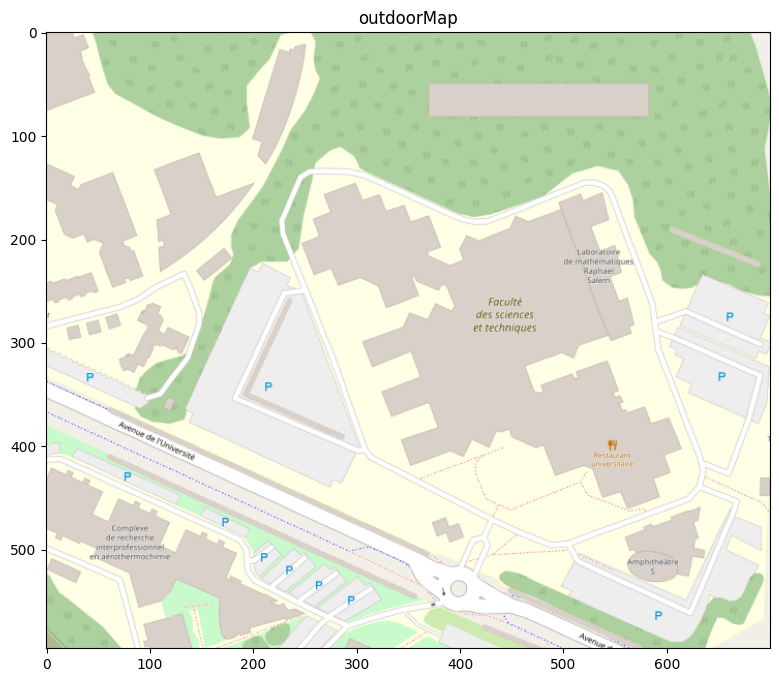

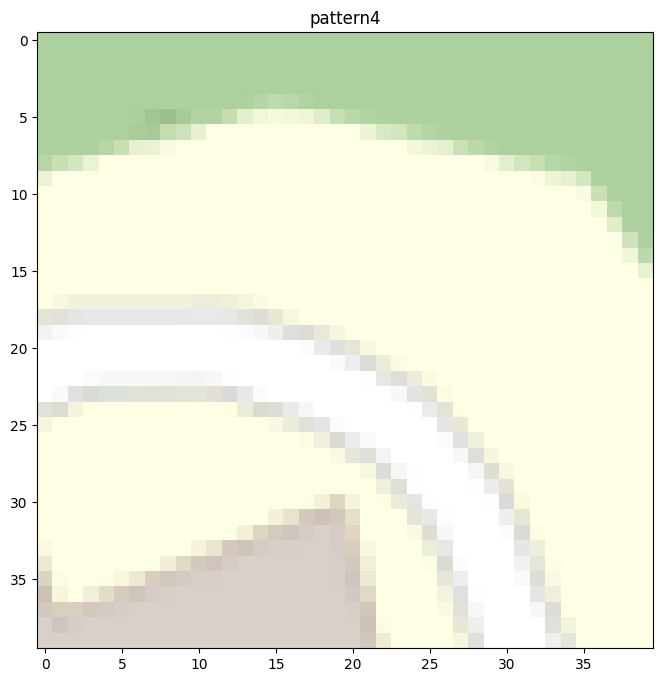

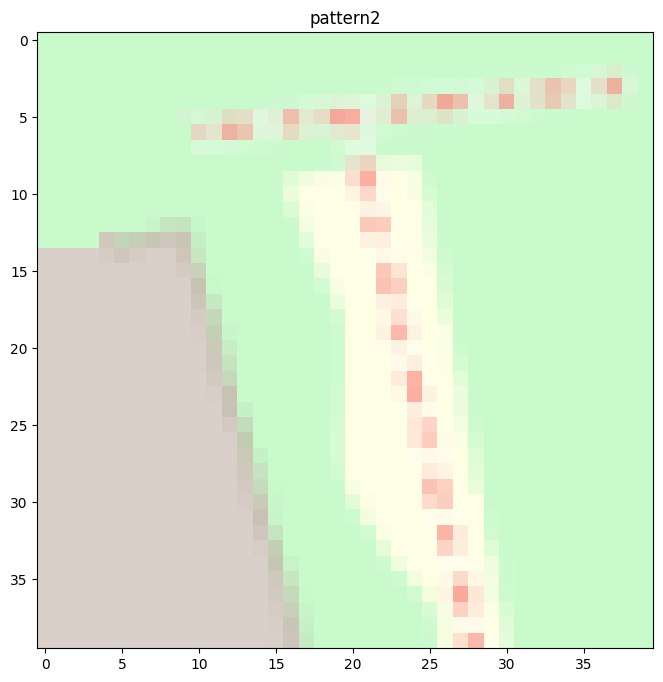

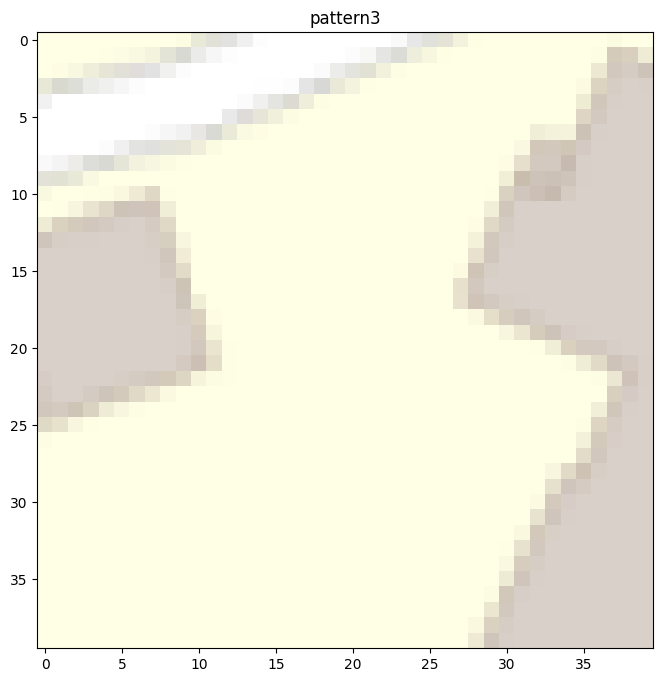

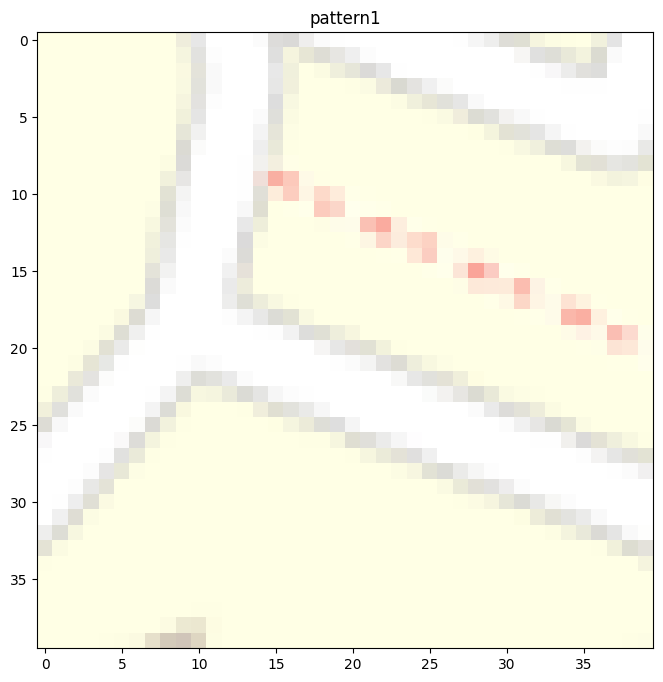

In [53]:
for img in images:
    plt.figure(figsize=(10, 8))
    plt.imshow(images[img])
    plt.title(img)

In [54]:
outdor_map = images["outdoorMap"]



wall_threshold = [217, 208, 201]


Text(0.5, 1.0, 'thresholded_map')

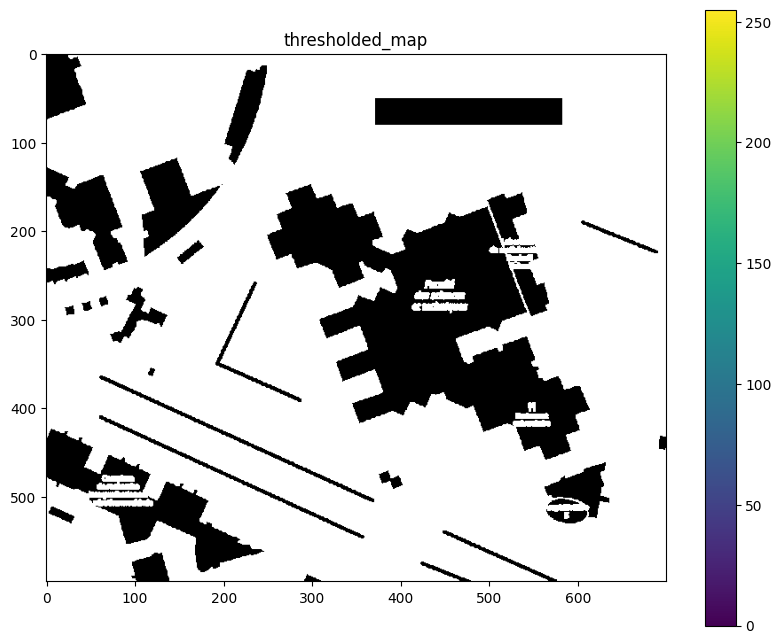

In [55]:
thresholded_map = outdor_map.copy()
mask = np.all(outdor_map == wall_threshold,axis=-1)
thresholded_map[mask] = 0
thresholded_map[~mask] = 255


plt.figure(figsize=(10, 8))
plt.imshow(thresholded_map)
plt.colorbar()
plt.title("thresholded_map")

Text(0.5, 1.0, 'map')

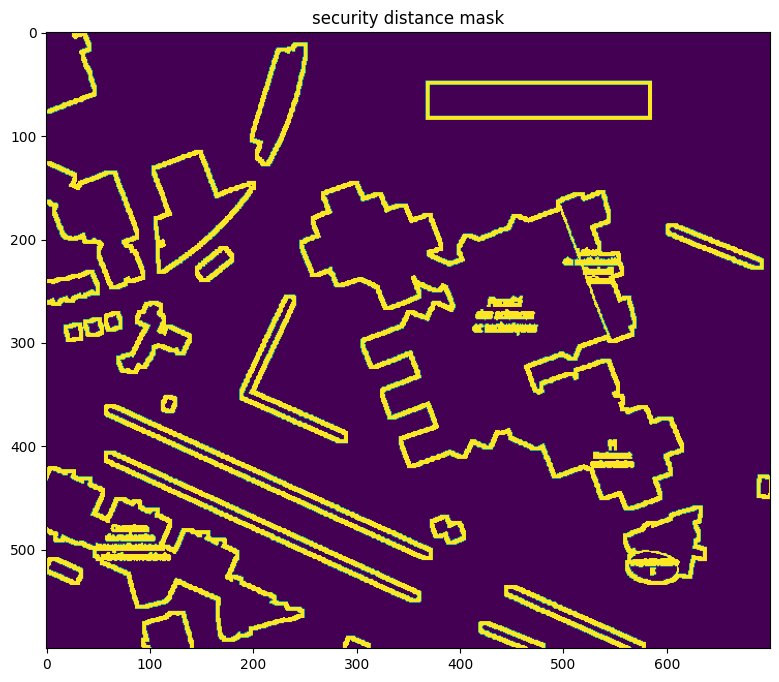

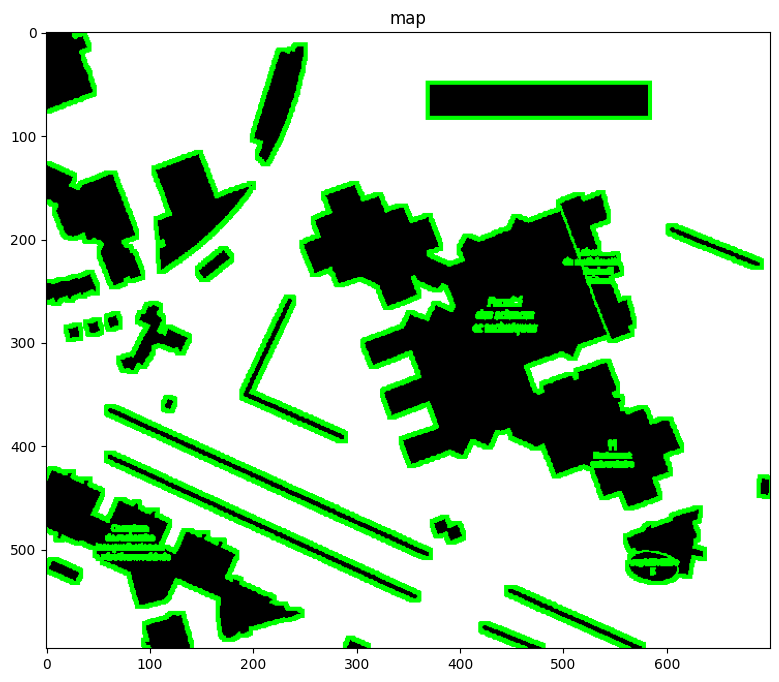

In [56]:
mask = np.all(outdor_map == wall_threshold, axis=-1)
mask = mask.astype(np.int8)*255

structurant = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))

eroded_mask = cv2.dilate(mask, kernel=structurant)
security_distance = eroded_mask & ~mask


plt.figure(figsize=(10, 8))
plt.imshow(security_distance)
plt.title("security distance mask")

thresholded_map[security_distance == 255] = [0, 255, 0]
plt.figure(figsize=(10, 8))
plt.imshow(thresholded_map)
plt.title("map")


In [57]:
class Point:
    """
        Point classe represente a pixel or a gray level in an image
    """
    
    # the pixel space of all points
    img = np.zeros((255, 255))
    wall_pixel = [0, 255, 0]
    def __init__(self, x, y , image=None) -> None:
        if image is not None:
            Point.set_point_space(image)
        self.y_Max = Point.img.shape[1]
        self.x_Max = Point.img.shape[0]
        if not (0<= x <= self.x_Max and  0 <= y <= self.y_Max):
            raise Exception(f"cordonates ({x}, {y}) out of image pixel space")
        self._x = x
        self._y = y
        self.h = 0
        

    def dist(self, A ):
        assert isinstance(A, Point); "TypeError"
        x, y = A.coord
        d = (self._x - x)**2 + (self._y - y)**2
        return np.sqrt(d)

    def _foor_neighbors(self):
        neighboors = [(self._x + i, self._y ) for i in [-1, 1]]
        neighboors += [(self._x , self._y + i) for i in [-1, 1]]
        neighboors = [neighboor for neighboor in neighboors if ( 0<= neighboor[0]< self.x_Max and 0<= neighboor[1]< self.y_Max)]
        for neighboor in neighboors:
            yield neighboor[0], neighboor[1]

    def foor_accessible_neighbors(self):
        for neighbor in self._foor_neighbors() :
            if   np.all(Point.img[neighbor] == [255, 255, 255], axis=-1):
                yield neighbor
    
    def _eight_neighbors(self):
        neighboors = [(self._x + i, self._y + j) for i in [-1,0, 1] for j in [-1,0, 1] if i*j + i+j != 0] 
        # this condition mean i != 0 and j!= 0

        neighboors = [neighboor for neighboor in neighboors if ( 0<= neighboor[0]< self.x_Max and 0<= neighboor[1]< self.y_Max)]
        for neighboor in neighboors:
            yield neighboor[0], neighboor[1]
    
    def eight_accesssible_neighboor(self):
        for neighbor in self._eight_neighbors() :
            if np.all(Point.img[neighbor] == [255, 255, 255], axis=-1):
                yield neighbor
    
    @classmethod
    def set_point_space(cls, img : np.ndarray):
        cls.img = img
    
    @property
    def coord(self):
        return self._x, self._y    
    
    def __hash__(self) -> int:
        return hash(str(self._x)+ str(self._y))
    
    def __eq__(self, __value: object) -> bool:
        return isinstance(__value, Point) and self.dist(__value) == 0
    
    def __str__(self) -> str:
        return f"({self._x}, {self._y})"
    
    def __repr__(self) -> str:
        return self.__str__()
    

In [58]:

Point.set_point_space(thresholded_map)
Point.wall_pixel = [0, 255, 0]

start_point = Point(100, 10)
end_point = Point(300, 600)
thresholded_map[end_point.coord]

array([255, 255, 255], dtype=uint8)

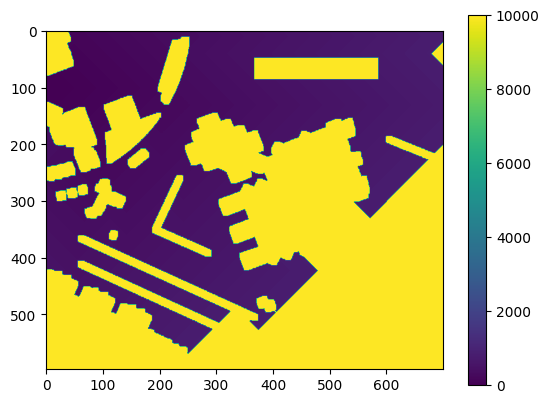

In [59]:

Point.set_point_space(thresholded_map)
Point.wall_pixel = [0, 255, 0]

start_point = Point(100, 10)
end_point = Point(300, 600)



M = 10000*np.ones(thresholded_map.shape[:2])
M[start_point.coord] = 0
list_point : List[Point] = []
list_point = [start_point]

while  len(list_point) >0  and end_point not in list_point:
    p0 = list_point[0]
    for neighbor in p0.foor_accessible_neighbors():
        if M[p0.coord] + 1 < M[neighbor]:
            M[neighbor] =  M[p0.coord] + 1
            list_point.append(Point(*neighbor))
    list_point.pop(0)
        #list_point = sorted(list_point, key=lambda x: x.h)


plt.imshow(M)
plt.colorbar()

In [60]:
if M[end_point.coord] == 10000:
    print('Destination innaccessible') 
else:
    p0 = end_point
    path = [p0]
    while p0 != start_point:
        p0 = Point(*min([pi for pi in p0.eight_accesssible_neighboor()] , key=lambda p: M[p]))
        path.append(p0)


Text(0.5, 1.0, 'map')

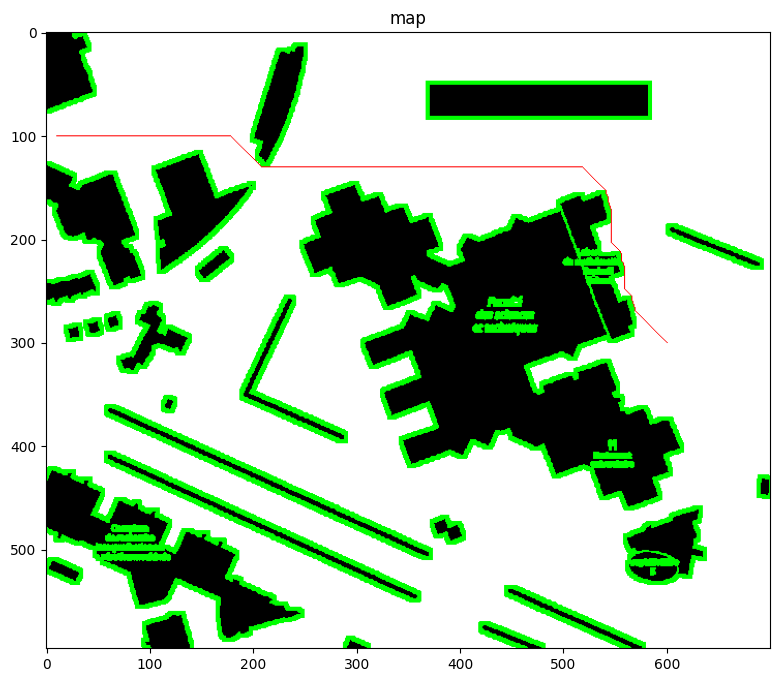

In [61]:

for point in path:
    thresholded_map[point.coord] = [255,0, 0]
    
plt.figure(figsize=(10, 8))
plt.imshow(thresholded_map)
plt.title("map")

Recapitulons


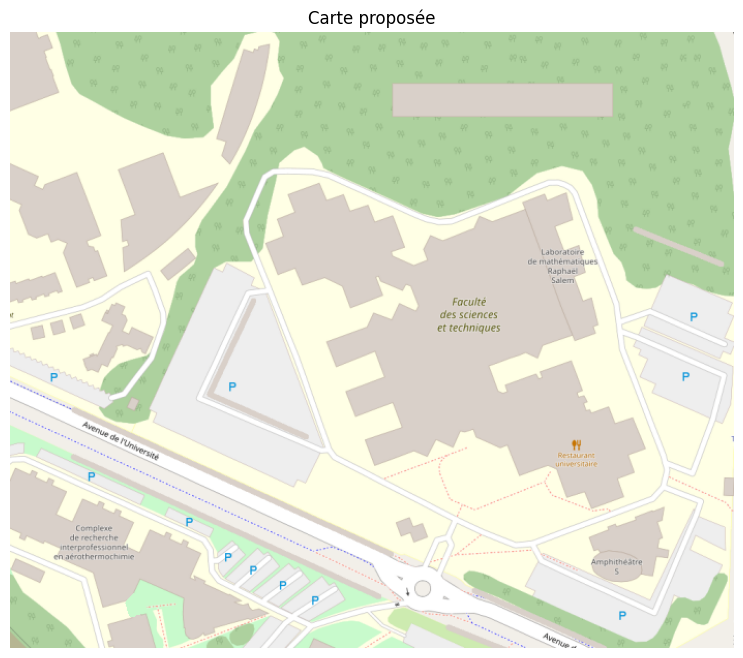

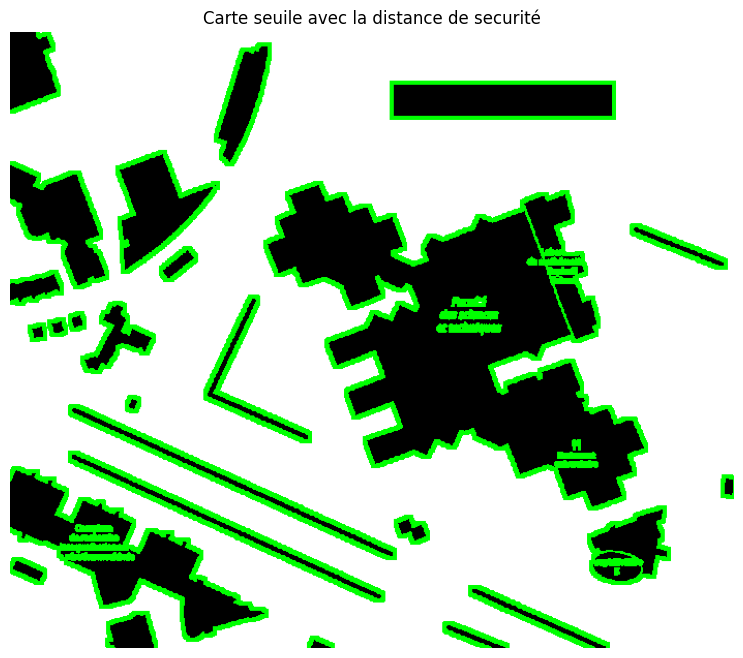

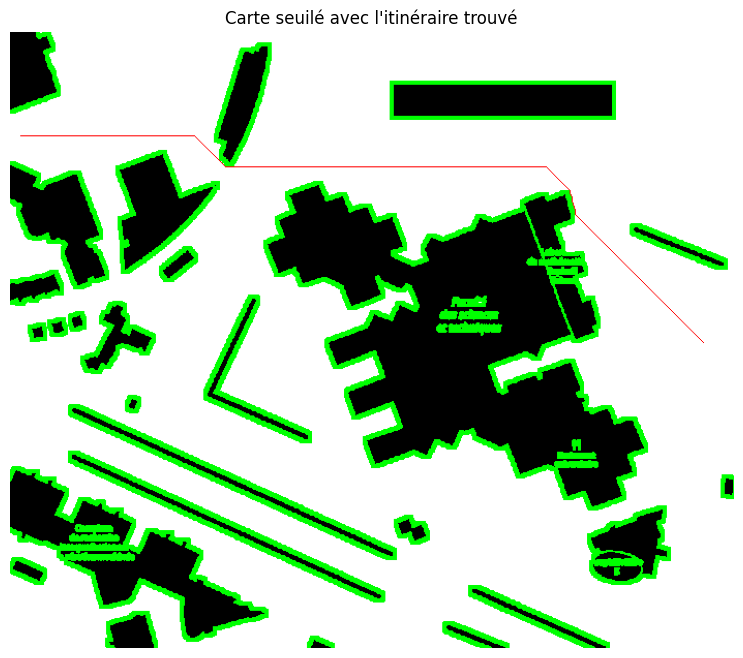

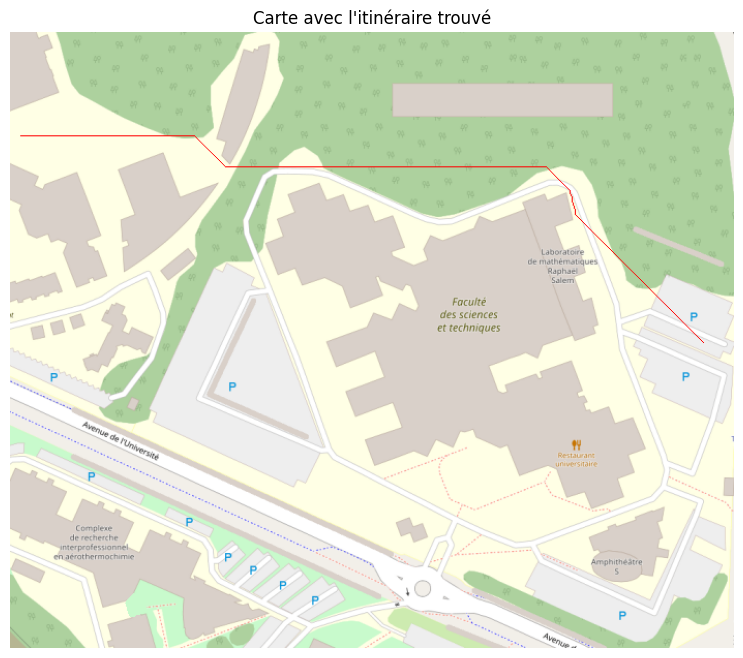

In [62]:
def transversal_graph(map_image : np.ndarray, 
                start_point : tuple, end_point : tuple, 
                obstacle_pixel = [217, 208, 201],   wall_pixel : List = [0, 255, 0],
                path_color : List = [255, 0, 0] # le chemin en rouge
                  ):
    
    # On seul notre catre en fonction du pixel des obstacle
    plt.figure(figsize=(10, 8))
    plt.title("Carte proposée")
    plt.axis("off")
    plt.imshow(map_image)

    thresholded_map = map_image.copy()
    mask = np.all(outdor_map == obstacle_pixel,axis=-1)
    thresholded_map[mask] = 0
    thresholded_map[~mask] = 255


    mask = mask.astype(np.int8)*255
    structurant = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))

    # on applique une dilatation à notre mask puis on fait la difference pour avoir la distance de securité avec les mure
    dilated_mask = cv2.dilate(mask, kernel=structurant)
    security_distance = dilated_mask & ~mask
    thresholded_map[security_distance == 255] = wall_pixel
    
    plt.figure(figsize=(10, 8))
    plt.title("Carte seuile avec la distance de securité")
    plt.axis("off")
    plt.imshow(thresholded_map)
    

    # nous allons travailler sur le carte suillé avec les distance de securité
    Point.set_point_space(thresholded_map)
    try:
        start_point = Point(*start_point)
        end_point = Point(*end_point)
    except Exception as e:
        print("le point de depart ou d'arrive sont invalide", e.args)
        return
    
    INF = 10*Point(0, 0).dist(Point(*Point.img.shape[:2])) #10  la diagonal de l'image

    distance_matrix = INF*np.ones(thresholded_map.shape[:2])
    distance_matrix[start_point.coord] = 0
    list_point : List[Point] = [start_point]

    
    while  len(list_point) >0  and end_point not in list_point:
        p0 = list_point[0]
        for neighbor in p0.foor_accessible_neighbors():
            if distance_matrix[p0.coord] + 1 < distance_matrix[neighbor]:
                distance_matrix[neighbor] =  distance_matrix[p0.coord] + 1
                list_point.append(Point(*neighbor))
        list_point.pop(0)
        #list_point = sorted(list_point, key=lambda x: distan)


    if M[end_point.coord] == INF:
        print('Destination innaccessible') 
        return

    
    p0 = end_point
    path = [p0]
    while p0 != start_point:
        p0 = Point(*min([pi for pi in p0.eight_accesssible_neighboor()] , key=lambda p: M[p]))
        path.append(p0)

    for point in path:
        thresholded_map[point.coord] = path_color

        
    plt.figure(figsize=(10, 8))
    plt.title("Carte seuilé avec l'itinéraire trouvé")
    plt.axis("off")
    plt.imshow(thresholded_map)


    
    plt.figure(figsize=(10, 8))
    map_with_path = map_image.copy()
    for point in path:
        map_with_path[point.coord] = path_color

    plt.title("Carte avec l'itinéraire trouvé")
    plt.axis("off")
    plt.imshow(map_with_path)


image = outdor_map
obstable = [217, 208, 201]

point_depart= (100, 10)
point_arrive = (300, 670)

transversal_graph(image, point_depart, point_arrive, obstacle_pixel=obstable)


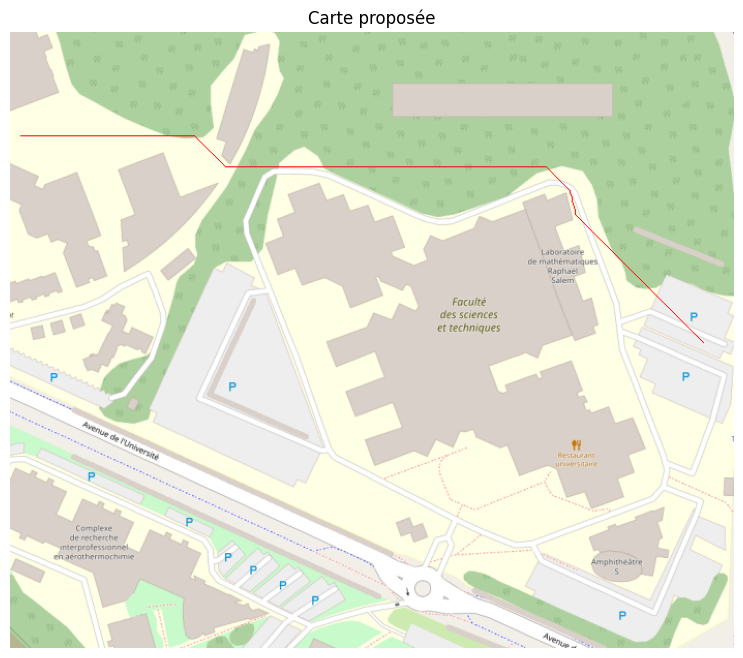

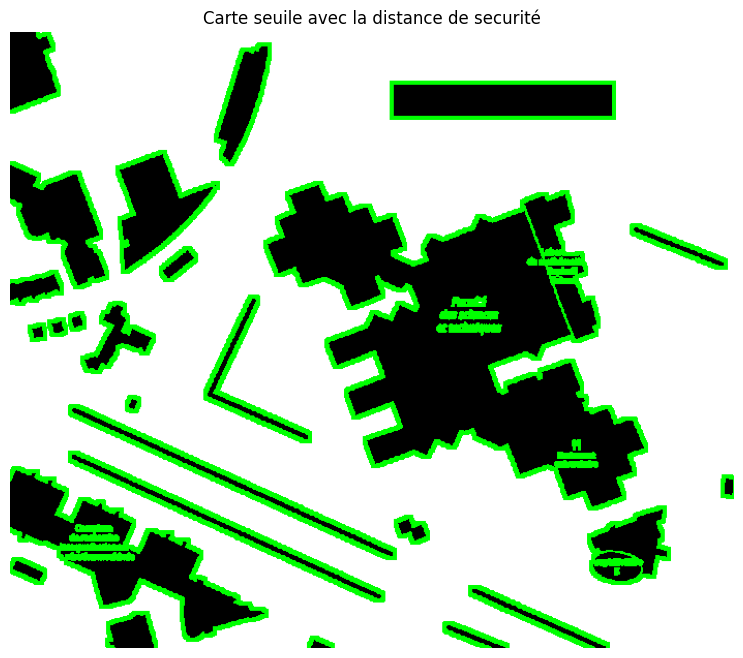

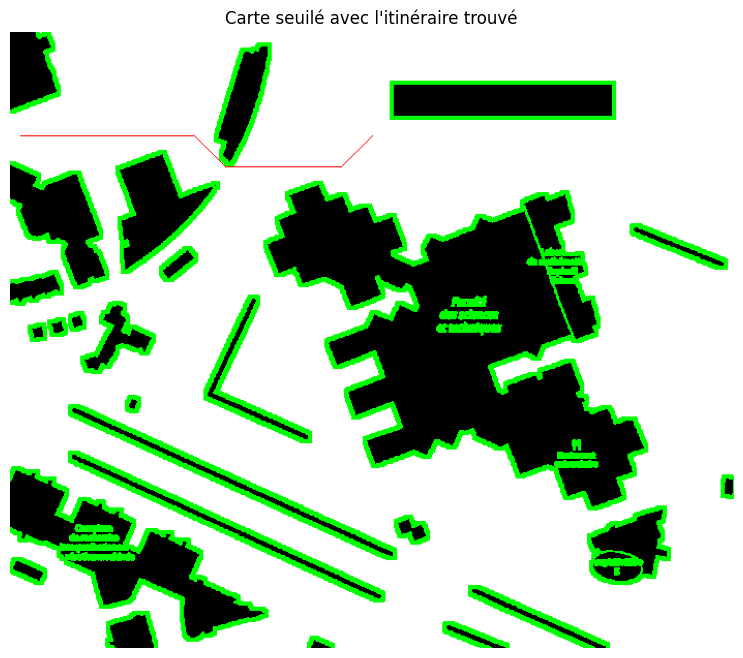

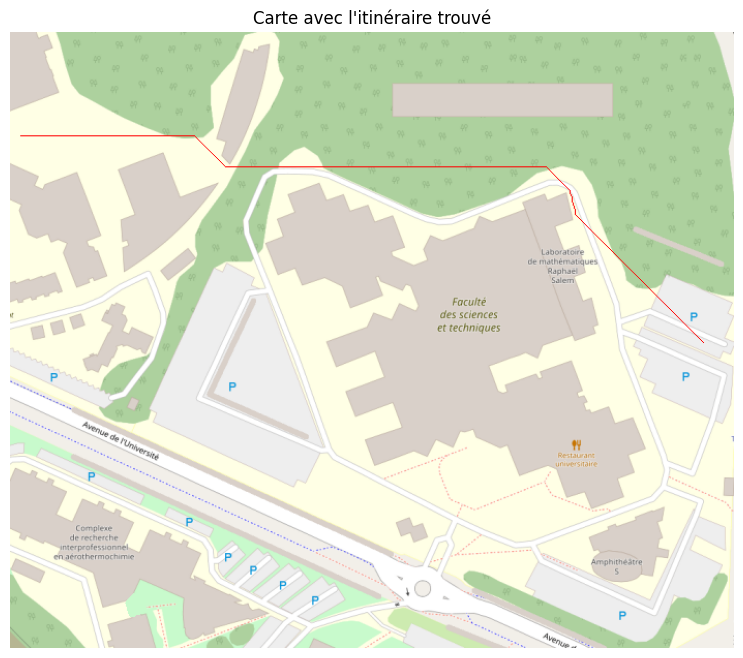

In [63]:
def path_finder_A_etoile(map_image : np.ndarray, 
                start_point : tuple, end_point : tuple, 
                obstacle_pixel = [217, 208, 201],   wall_pixel : List = [0, 255, 0],
                path_color : List = [255, 0, 0] # le chemin en rouge
                  ):
    
    # On seul notre catre en fonction du pixel des obstacle
    plt.figure(figsize=(10, 8))
    plt.title("Carte proposée")
    plt.axis("off")
    plt.imshow(map_image)

    thresholded_map = map_image.copy()
    mask = np.all(outdor_map == obstacle_pixel,axis=-1)
    thresholded_map[mask] = 0
    thresholded_map[~mask] = 255


    mask = mask.astype(np.int8)*255
    structurant = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))

    # on applique une dilatation à notre mask puis on fait la difference pour avoir la distance de securité avec les mure
    dilated_mask = cv2.dilate(mask, kernel=structurant)
    security_distance = dilated_mask & ~mask
    thresholded_map[security_distance == 255] = wall_pixel
    
    plt.figure(figsize=(10, 8))
    plt.title("Carte seuile avec la distance de securité")
    plt.axis("off")
    plt.imshow(thresholded_map)
    

    # nous allons travailler sur le carte suillé avec les distance de securité
    Point.set_point_space(thresholded_map)
    try:
        start_point = Point(*start_point)
        end_point = Point(*end_point)
    except Exception as e:
        print("le point de depart ou d'arrive sont invalide", e.args)
        return
    
    INF = 10*Point(0, 0).dist(Point(*Point.img.shape[:2])) #10  la diagonal de l'image

    distance_matrix = INF*np.ones(thresholded_map.shape[:2])
    distance_matrix[start_point.coord] = 0
    list_point : List[Point] = [start_point]


      
    while  len(list_point) >0  and end_point not in list_point:
        p0 = list_point[0]
        for neighbor in p0.foor_accessible_neighbors():
            if distance_matrix[p0.coord] + 1 < distance_matrix[neighbor]:
                distance_matrix[neighbor] =  distance_matrix[p0.coord] + 1
                p= Point(*neighbor)
                p.h = distance_matrix[p.coord] + p.dist(end_point)
                list_point.append(p)
        list_point.pop(0)
        list_point = sorted(list_point, key=lambda x: x.h)


    if M[end_point.coord] == INF:
        print('Destination innaccessible') 
        return

    p0 = end_point
    path = [p0]
    while p0 != start_point:
        p0 = Point(*min([pi for pi in p0.eight_accesssible_neighboor()] , key=lambda p: M[p]))
        path.append(p0)

    for point in path:
        thresholded_map[point.coord] = path_color

        
    plt.figure(figsize=(10, 8))
    plt.title("Carte seuilé avec l'itinéraire trouvé")
    plt.axis("off")
    plt.imshow(thresholded_map)


    
    plt.figure(figsize=(10, 8))
    map_with_path = map_image.copy()
    for point in path:
        map_with_path[point.coord] = path_color

    plt.title("Carte avec l'itinéraire trouvé")
    plt.axis("off")
    plt.imshow(map_with_path)


image = outdor_map
obstable = [217, 208, 201]

point_depart= (100, 10)
point_arrive = (100, 350)

path_finder_A_etoile(image, point_depart, point_arrive, obstacle_pixel=obstable)


# L'algorithme Weighted A*

KeyboardInterrupt: 

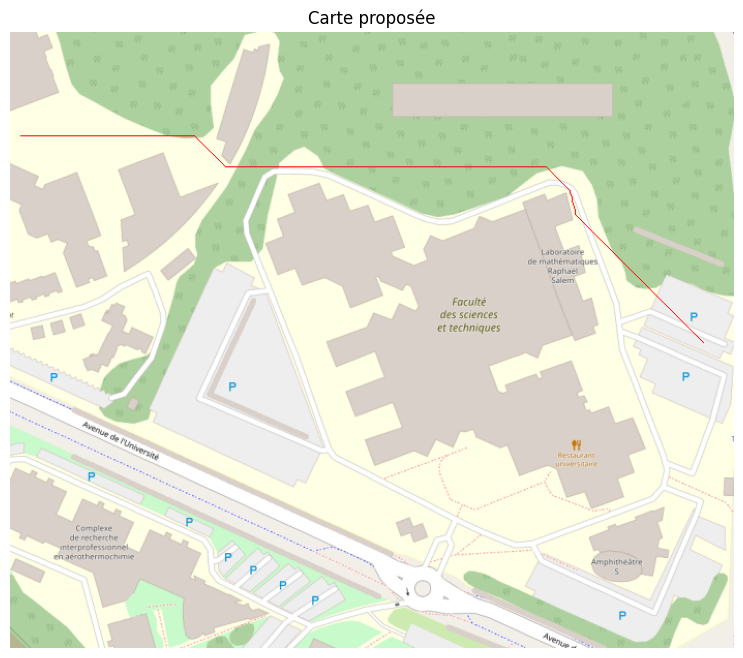

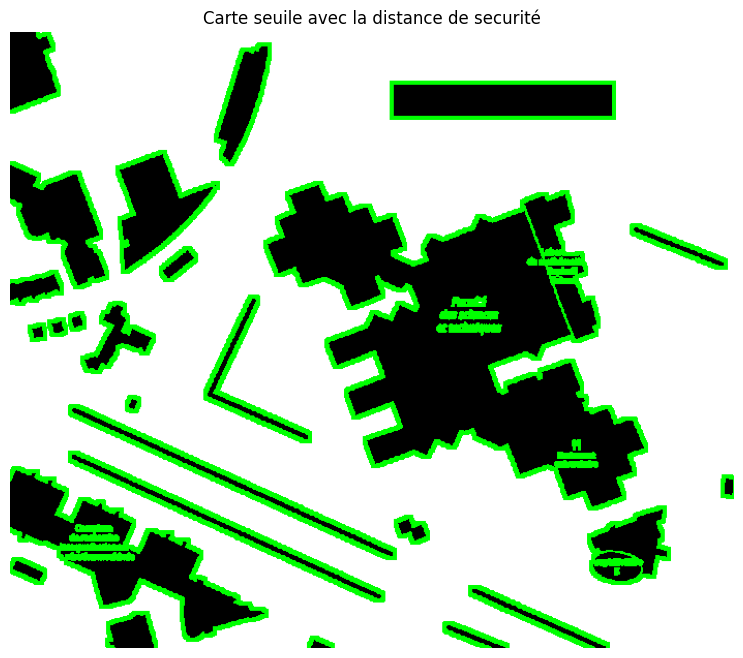

In [72]:
def path_finder_A_etoile_weigthed(map_image : np.ndarray, 
                start_point : tuple, end_point : tuple,weight , 
                obstacle_pixel = [217, 208, 201],   wall_pixel : List = [0, 255, 0],
                path_color : List = [255, 0, 0] # le chemin en rouge
                  ):
    
    # On seul notre catre en fonction du pixel des obstacle
    plt.figure(figsize=(10, 8))
    plt.title("Carte proposée")
    plt.axis("off")
    plt.imshow(map_image)

    thresholded_map = map_image.copy()
    mask = np.all(outdor_map == obstacle_pixel,axis=-1)
    thresholded_map[mask] = 0
    thresholded_map[~mask] = 255


    mask = mask.astype(np.int8)*255
    structurant = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))

    # on applique une dilatation à notre mask puis on fait la difference pour avoir la distance de securité avec les mure
    dilated_mask = cv2.dilate(mask, kernel=structurant)
    security_distance = dilated_mask & ~mask
    thresholded_map[security_distance == 255] = wall_pixel
    
    plt.figure(figsize=(10, 8))
    plt.title("Carte seuile avec la distance de securité")
    plt.axis("off")
    plt.imshow(thresholded_map)
    

    # nous allons travailler sur le carte suillé avec les distance de securité
    Point.set_point_space(thresholded_map)
    try:
        start_point = Point(*start_point)
        end_point = Point(*end_point)
    except Exception as e:
        print("le point de depart ou d'arrive sont invalide", e.args)
        return
    
    INF = 10*Point(0, 0).dist(Point(*Point.img.shape[:2])) #10  la diagonal de l'image

    distance_matrix = INF*np.ones(thresholded_map.shape[:2])
    distance_matrix[start_point.coord] = 0
    list_point : List[Point] = [start_point]

    while  len(list_point) >0  and end_point not in list_point:
            p0 = list_point[0]
            for neighbor in p0.foor_accessible_neighbors():
                if distance_matrix[p0.coord] + 1 < distance_matrix[neighbor]:
                    distance_matrix[neighbor] =  distance_matrix[p0.coord] + 1
                    p= Point(*neighbor)
                    p.h = distance_matrix[p.coord] + weight*p.dist(end_point)
                    list_point.append(p)
            list_point.pop(0)
            list_point = sorted(list_point, key=lambda x: x.h)


    if M[end_point.coord] == INF:
        print('Destination innaccessible') 
        return

    p0 = end_point
    path = [p0]
    while p0 != start_point:
        p0 = Point(*min([pi for pi in p0.eight_accesssible_neighboor()] , key=lambda p: M[p]))
        path.append(p0)

    for point in path:
        thresholded_map[point.coord] = path_color

        
    plt.figure(figsize=(10, 8))
    plt.title("Carte seuilé avec l'itinéraire trouvé")
    plt.axis("off")
    plt.imshow(thresholded_map)


    
    plt.figure(figsize=(10, 8))
    map_with_path = map_image.copy()
    for point in path:
        map_with_path[point.coord] = path_color

    plt.title("Carte avec l'itinéraire trouvé")
    plt.axis("off")
    plt.imshow(map_with_path)


image = outdor_map
obstable = [217, 208, 201]

point_depart= (100, 10)
point_arrive = (450, 657)

path_finder_A_etoile_weigthed(image, point_depart, point_arrive, 2, obstacle_pixel=obstable)


In [69]:
point_arrive = Point(450, 657)

thresholded_map[point_arrive.coord]

array([255, 255, 255], dtype=uint8)